# Simulation of Aging Through Damage Accumulation

This project uses a stochastic differential equation to simulate damage accumulation with age. The rate of damage accumulation increases with age, and the rate of removal is modeled with a Hill function, meaning it will saturate at high amounts of damage.

The equation used is:

$$
\frac{dx}{dt} = \eta t - \beta \frac{x}{x+\kappa} + \sqrt{2\epsilon}\xi
$$

where:

- $x$ is the accumulated damage
- $t$ is time
- $\eta$ is the rate of damage accumulation
- $\beta$ is the rate of damage repair
- $\kappa$ is the repair saturation constant
- $\epsilon$ is the noise amplitude
- $\xi$ is Gaussian white noise

This equation was first published by Karin et al. (2019): [https://doi.org/10.1038/s41467-019-13192-4](https://doi.org/10.1038/s41467-019-13192-4).

The damage accumulation equation is integrated over time using the Euler-Maruyama method in multiple organisms. When the damage reaches a cutoff value, the organism is considered dead. A histogram of lifespans, survival curves, mortality and average amount of damage accumulated are plotted for each simulation.

In [1]:
from matplotlib import pyplot
import numpy
import multiprocess

In [2]:
# Functions for plotting mortality and survival curves

def plot_mortality(mortality_array, age_unit = "years", time_span = 1, scale="log"):
    """
    Plot the mortality curve over age.

    Parameters:
        mortality_array (array-like): Array of mortality rates per time step.
        age_unit (str): Label for the age axis.
        time_span (float): Time interval per step.
        scale (str): Y-axis scale ('log' or 'linear').
    """
    figure, axis = pyplot.subplots()
    age_array = numpy.arange(len(mortality_array)) * time_span
    axis.plot(age_array, mortality_array)
    axis.set_xlabel(f"Age ({age_unit})")
    axis.set_ylabel(f"Mortality, {time_span} {age_unit}")
    axis.grid()
    axis.set_yscale(scale)
    return

def proportion_alive(mortality_array):
    """
    Calculate the proportion alive at each time step given mortality rates.

    Parameters:
        mortality_array (array-like): Array of mortality rates per time step.

    Returns:
        list: Proportion alive at each time step.
    """
    alive_list = [1]
    for mortality in mortality_array:
        alive = alive_list[-1]*(1-mortality)
        alive_list.append(alive)
    return alive_list

def survival_curve(proportion_alive_array, age_unit = "years", starting_age = 0):
    """
    Plot the survival curve over age.

    Parameters:
        proportion_alive_array (array-like): Proportion alive at each time step.
        age_unit (str): Label for the age axis.
        starting_age (int): Starting age for the x-axis.
    """
    age_array = list(range(starting_age, len(proportion_alive_array) + starting_age))
    figure, axis = pyplot.subplots()
    axis.plot(age_array, proportion_alive_array)
    axis.set_xlabel(f"Age ({age_unit})")
    axis.set_ylabel("Proportion alive")
    axis.grid()
    return

In [3]:
# Functions for stochastic simulations of lifespan trajectories

def single_damage_accumulation(time, concentrations, dt, xi, eta, beta, kappa, epsilon):
    """
    Compute the change in damage for a single time step using the stochastic ODE.

    Parameters:
        time (float): Current time.
        concentrations (array-like): Current damage values.
        dt (float): Time step.
        xi (float): Random normal variable for noise.
        eta, beta, kappa, epsilon (float): Model parameters.

    Returns:
        array-like: Change in damage.
    """
    dc = dt * (eta*time - beta*concentrations/(concentrations+kappa)) + \
    numpy.sqrt(2*epsilon*dt)*xi
    return dc

def solve_stochastic(derivatives_function, initial_values, time_span, dt=1e-5,
                     negatives = True, seed=None, parameters = []):
    """
    Integrate a stochastic ODE using the Euler-Maruyama method.

    Parameters:
        derivatives_function (callable): Function to compute derivatives.
        initial_values (array-like): Initial state.
        time_span (tuple): (start, stop) time.
        dt (float): Time step.
        negatives (bool): If True, allow negative values.
        seed (int or None): RNG seed.
        parameters (list): Additional parameters for the derivatives function.

    Returns:
        tuple: (time_array, concentration_matrix)
    """
    time_array = numpy.arange(*time_span, dt)
    concentration_matrix = [initial_values.copy()]
    
    rng = numpy.random.default_rng(seed = seed)
    
    for t in time_array[:-1]:
        xi = rng.normal()
        concentrations = concentration_matrix[-1]
        #parameters = xi, eta, beta, kappa, epsilon
        dc = derivatives_function(t, concentrations, dt, xi, *parameters)
        if negatives:
            new_concentrations = concentrations + dc
        else:
            new_concentrations = numpy.clip(concentrations + dc, a_min=0, a_max=None)
        concentration_matrix.append(new_concentrations)
    return time_array, numpy.array(concentration_matrix)

def population_simulation(damage_function, death_function, initial_values, population_size = 1000, processes = 16, dt = 1, time_span = [0, 1500], time_unit = "years",
                          parameters = [], name = ""):
    """
    Run a population simulation of stochastic damage accumulation and plot results.

    Parameters:
        damage_function (callable): Function for damage accumulation.
        death_function (callable): Function to determine death index.
        initial_values (array-like): Initial damage values.
        population_size (int): Number of individuals to simulate.
        processes (int): Number of parallel processes.
        dt (float): Time step.
        time_span (list): [start, stop] time.
        time_unit (str): Label for time axis.
        parameters (list): Parameters for the damage function.
        name (str): Simulation name.

    Returns:
        numpy.ndarray: Array of simulated lifespans.
    """
    print(f"Running aging simulation: {name}")

    lifespan_list = []
    process_pool = multiprocess.Pool(processes)
    simulation_results = []
    for individual in range(population_size):
        result = process_pool.apply_async(solve_stochastic,
                                          [damage_function, initial_values, time_span, dt],
                                          {"negatives": False, "parameters": parameters})
        simulation_results.append(result)

    print(f"\rIndividual 0/{population_size}", end="")
    concentration_matrix_list = []
    for simulation_index, result in enumerate(simulation_results):
        time_array, concentration_matrix = tuple(result.get())
        concentration_matrix_list.append(concentration_matrix)
        death_index = death_function(concentration_matrix)
        lifespan = death_index * dt
        lifespan_list.append(lifespan)
        print(f"\rIndividual {simulation_index+1}/{population_size}", end="")
    process_pool.close()
    process_pool.join()
    concentration_matrix_array = numpy.array(concentration_matrix_list)
    print()
    
    lifespan_array = numpy.array(lifespan_list)
    average_lifespan = numpy.mean(lifespan_array)
    median_lifespan = numpy.median(lifespan_array)
    lifespan_stdev = numpy.std(lifespan_array)
    print(f"Average lifespan: {average_lifespan} {time_unit}")
    print(f"Median lifespan: {median_lifespan} {time_unit}")
    print(f"Standard deviation in lifespan: {lifespan_stdev}")
    print(f"Steepness: {average_lifespan/lifespan_stdev}")
    print(f"99th percentile: {numpy.percentile(lifespan_array, 99)} {time_unit}")

    # Plot lifespans
    figure, axis = pyplot.subplots()
    axis.hist(lifespan_array, bins=100)
    axis.set_xlabel(f"Lifespan ({time_unit})")
    axis.set_ylabel("Number of individuals")
    axis.grid()
    
    # Make survival curve
    proportion_alive_list = []
    for age in numpy.arange(time_span[0], time_span[1]+1, 1):
        alive = numpy.sum(lifespan_array > age) / len(lifespan_array)
        proportion_alive_list.append(alive)
    survival_curve(proportion_alive_list)
        
    # Plot mortality
    mortality_list = []
    bin_width = round((time_span[1]-time_span[0]) / 100)
    for age in range(0, len(proportion_alive_list)-bin_width, bin_width):
        start_alive = proportion_alive_list[age]
        if start_alive == 0:
            break
        end_alive = proportion_alive_list[age+bin_width]
        mortality = 1 - end_alive / start_alive
        mortality_list.append(mortality)
    plot_mortality(mortality_list, age_unit = time_unit, time_span = bin_width)
    
    # Plot damage
    plot_damage(time_array, concentration_matrix_array, time_unit = time_unit)
    
    return lifespan_array

def death_cutoff_function(concentration_matrix):
    """
    Determine the time index when damage exceeds the death cutoff.

    Parameters:
        concentration_matrix (numpy.ndarray): Damage values over time.

    Returns:
        int: Index of death.
    """
    death_cutoff = 17
    dead_indices = numpy.any(concentration_matrix > death_cutoff, axis = 1)
    death_index = numpy.argmax(dead_indices)
    return death_index

def plot_damage(time_array, concentration_matrices, time_unit = "years"):
    """
    Plot average damage accumulation over time for each damage type.

    Parameters:
        time_array (array-like): Array of time points.
        concentration_matrices (numpy.ndarray): Damage values for all individuals.
        time_unit (str): Label for time axis.
    """
    damage_types = concentration_matrices.shape[-1]
    figure_list, axis_list = pyplot.subplots(1, damage_types, sharey=True)
    for damage_index in range(damage_types):
        if damage_types > 1:
            axis = axis_list[damage_index]
        else:
            axis = axis_list
        concentration_array = concentration_matrices[:, :, damage_index]
        average_damage = numpy.mean(concentration_array, axis = 0)
        axis.plot(time_array, average_damage)
        axis.set_xlabel(f"Time ({time_unit})")
        if damage_index == 0:
            axis.set_ylabel("Average damage accumulated")
        axis.set_title(f"Type {damage_index+1}")
        axis.grid()

A simulation was done with 1000 humans, using parameters from Yang et al., 2025 (https://doi.org/10.1038/s41467-025-57807-5). The parameters are:

- $\eta = 1.4 \times 10^{-3} \times 365.25$ $\mathrm{year}^{-2}$
- $\beta = 0.15 \times 365.25$ $\mathrm{year}^{-1}$
- $\kappa = 0.5$
- $\epsilon = 0.16 \times 365.25$ $\mathrm{year}^{-1}$
- Damage cutoff: $x = 17$

where time is measured in years.

Running aging simulation: Human no intervention
Individual 1000/1000
Average lifespan: 73.806173853525 years
Median lifespan: 75.29089664613278 years
Standard deviation in lifespan: 12.410236282922215
Steepness: 5.947201340162236
99th percentile: 96.67488021902805 years
Done


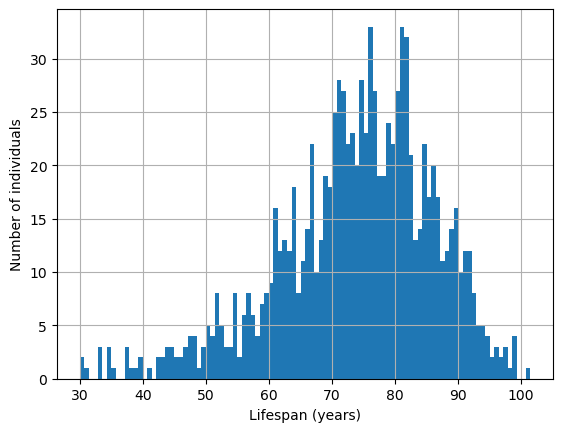

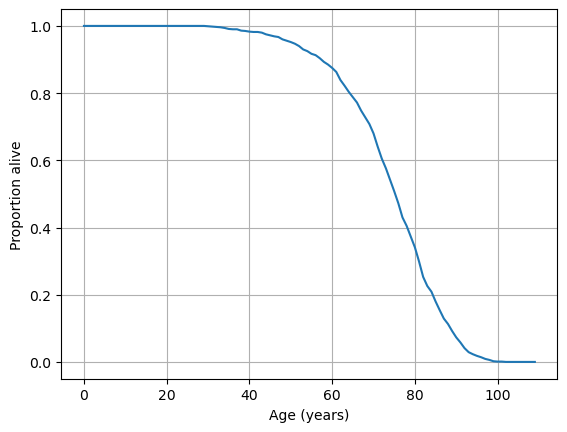

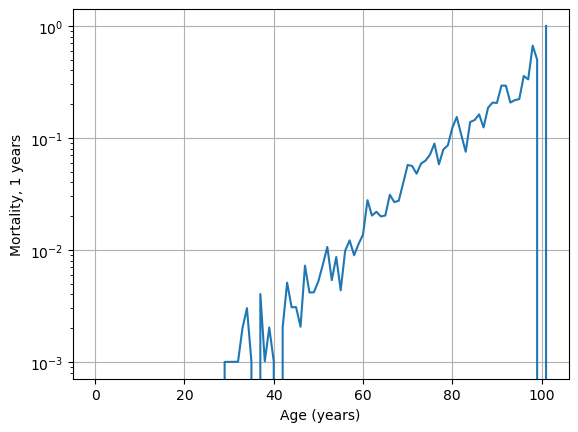

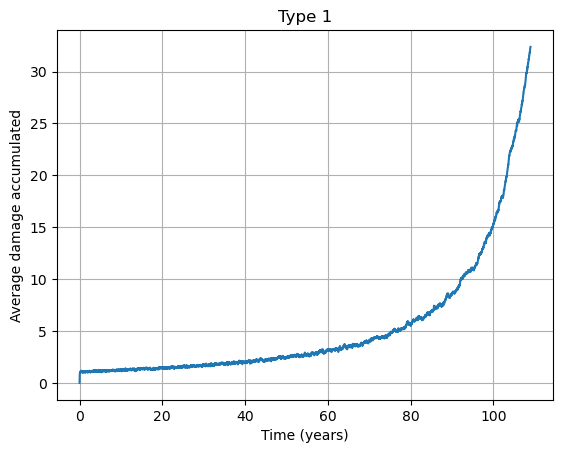

In [4]:
# Human lifespan simulation

eta = 1.4e-3 * 365.25 #/year²
beta = 0.15 * 365.25 #/year
kappa = 0.5
epsilon = 0.16 * 365.25 #/year
parameters = [eta, beta, kappa, epsilon]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(single_damage_accumulation, death_cutoff_function, initial_damage,
                                       population_size=1000, dt=5/365.25,
                                       time_span=[0, 109], time_unit="years", parameters=parameters,
                                       name="Human no intervention")

print("Done")

A simulation was also done with 2000 mice, using the following parameters:

- $\eta = 2.4 \times 10^{-4}$ $\mathrm{day}^{-2}$
- $\beta = 0.15$ $\mathrm{day}^{-1}$
- $\kappa = 0.5$
- $\epsilon = 0.16$ $\mathrm{day}^{-1}$
- Damage cutoff: $x = 17$

where time is measured in days.

Running aging simulation: Mouse no intervention
Individual 2000/2000
Average lifespan: 835.3775 days
Median lifespan: 840.0 days
Standard deviation in lifespan: 127.82771997399469
Steepness: 6.535182667499268
99th percentile: 1107.01 days


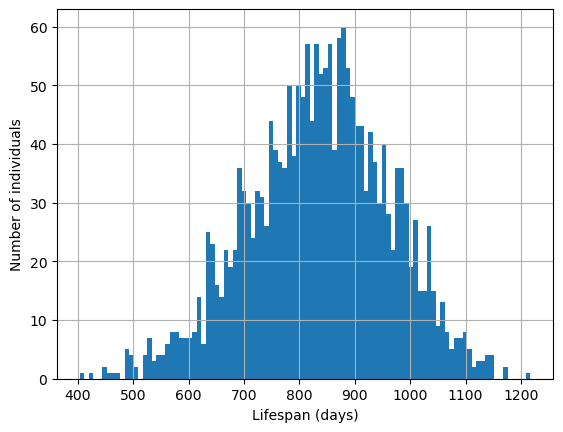

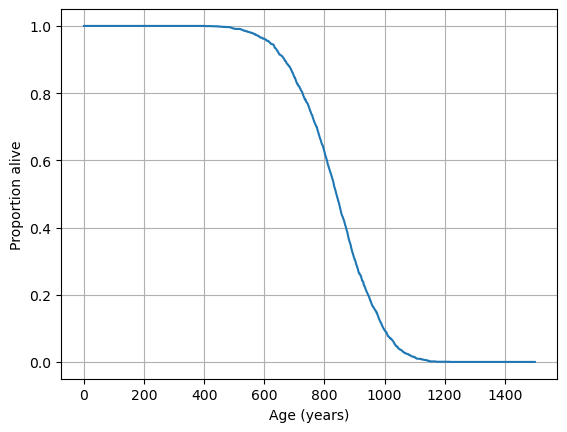

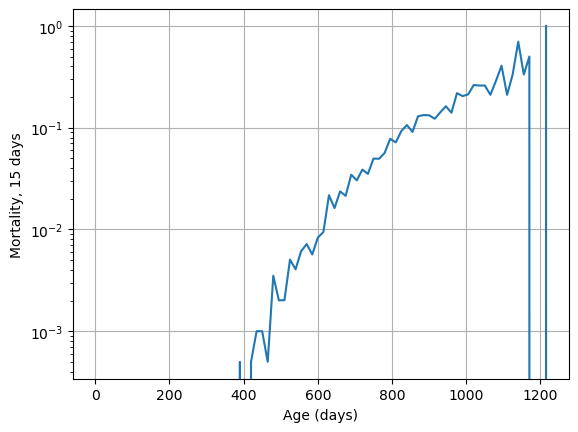

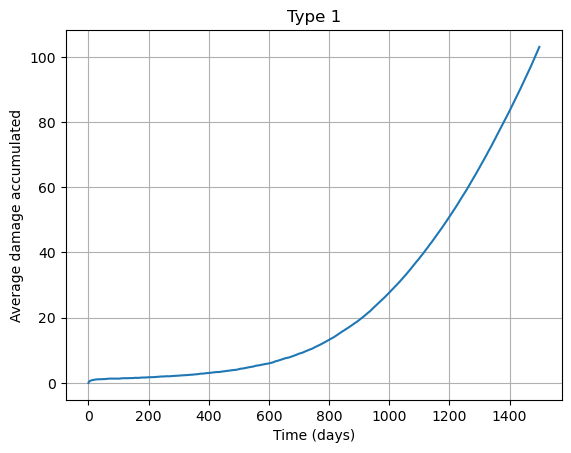

In [5]:
# Mouse lifespan simulation
    
eta = 2.4e-4 #/day²
beta = 0.15 #/day
kappa = 0.5
epsilon = 0.16 #/year
parameters = [eta, beta, kappa, epsilon]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(single_damage_accumulation, death_cutoff_function, initial_damage,
                                       population_size=2000, dt=1,
                                       time_span=[0, 1500], time_unit="days", parameters=parameters,
                                       name="Mouse no intervention")

Next, the effect of several interventions on lifespan was tested. These include slowing damage accumulation by 30%, increasing the rate of repair by 30% and directly repairing 50% of the damage. All interventions were applied at an age of 800 days.

Running aging simulation: Mouse slowed damage accumulation
Individual 2000/2000
Average lifespan: 923.352 days
Median lifespan: 876.5 days
Standard deviation in lifespan: 226.67237391442302
Steepness: 4.073509197678401
99th percentile: 1430.05 days


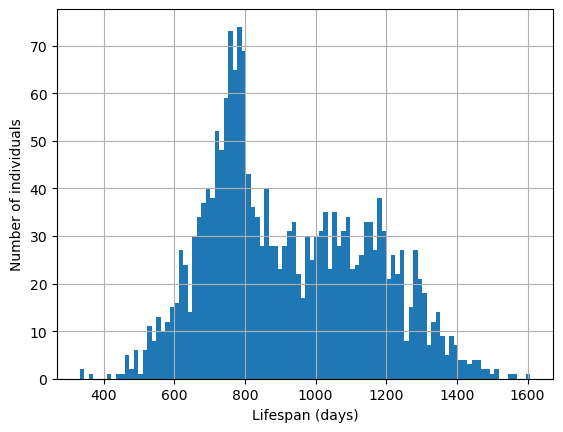

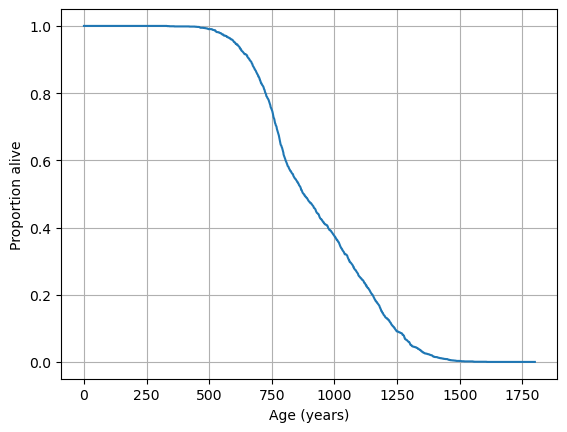

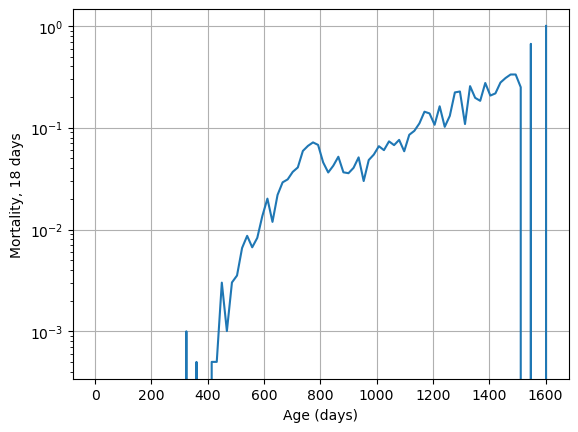

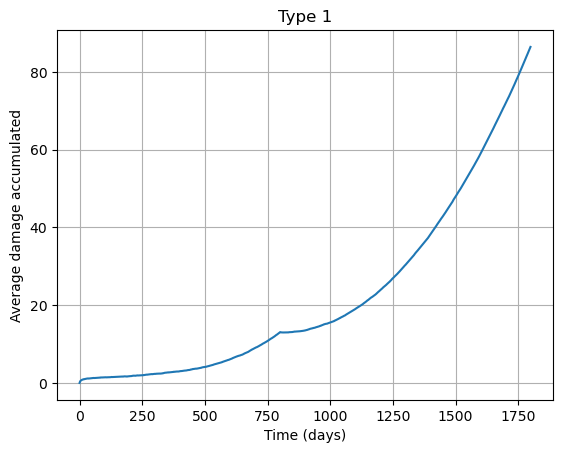

In [6]:
# Slowing damage accumulation at one point in life

def damage_accumulation_perturbation(time, concentrations, dt, xi, parameter_list, parameter_changed, new_value,
                                     onset_time):
    """
    Damage accumulation with a parameter change (perturbation) at a specified onset time.

    Parameters:
        time (float): Current time.
        concentrations (array-like): Current damage values.
        dt (float): Time step.
        xi (float): Random normal variable for noise.
        parameter_list (list): List of parameters to modify.
        parameter_changed (int): Index of parameter to change.
        new_value (float): New value for the parameter.
        onset_time (float): Time at which to change the parameter.

    Returns:
        array-like: Change in damage.
    """
    if time >= onset_time:
        parameter_list[parameter_changed] = new_value
    return single_damage_accumulation(time, concentrations, dt, xi, *parameter_list)

eta = 2.4e-4 #/day²
new_eta = 2.4e-4*0.7 #/day²
beta = 0.15 #/day
kappa = 0.5
epsilon = 0.16 #/year
parameters = [[eta, beta, kappa, epsilon], 0, new_eta, 800]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(damage_accumulation_perturbation, death_cutoff_function, initial_damage,
                                       population_size=2000, dt=1,
                                       time_span=[0, 1800], time_unit="days", parameters=parameters,
                                       name = "Mouse slowed damage accumulation")

Running aging simulation: Mouse increased damage repair
Individual 2000/2000
Average lifespan: 881.394 days
Median lifespan: 872.0 days
Standard deviation in lifespan: 177.28419772782908
Steepness: 4.971644462938186
99th percentile: 1257.04 days


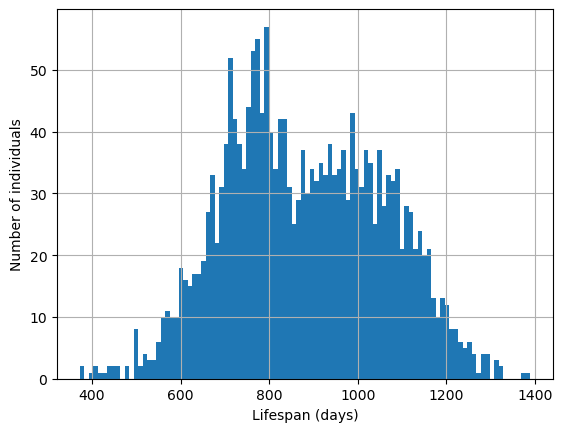

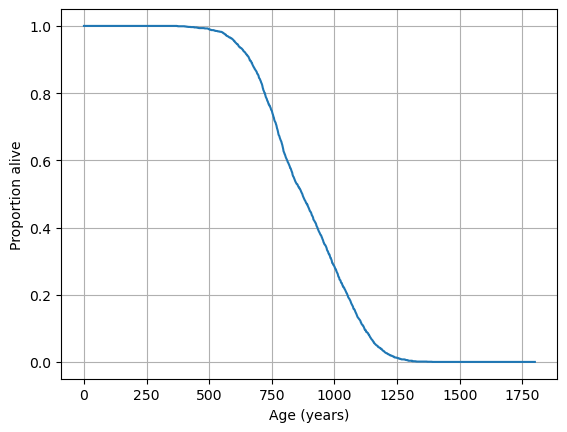

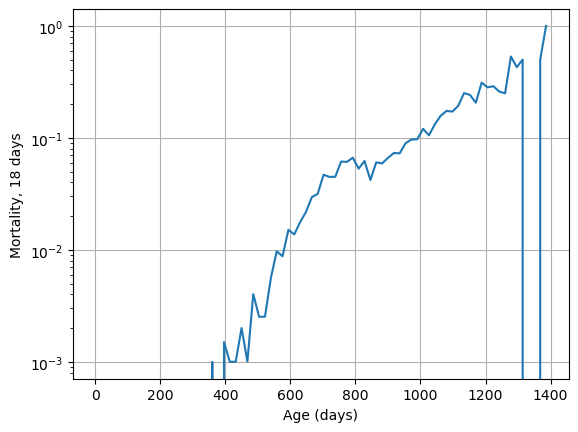

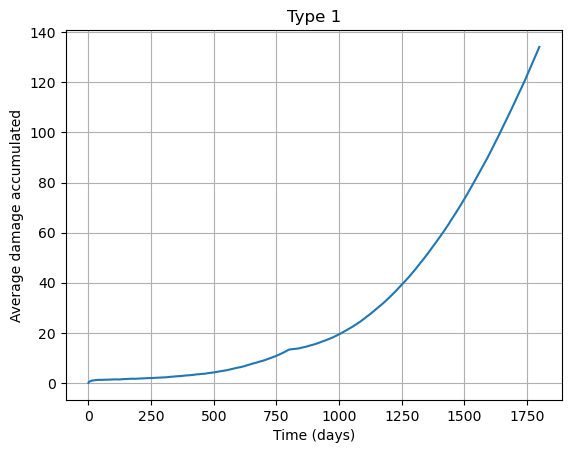

In [7]:
#%% Increased damage repair

eta = 2.4e-4 #/day²
beta = 0.15 #/day
new_beta = 0.15*1.3 #/day
kappa = 0.5
epsilon = 0.16 #/year
parameters = [[eta, beta, kappa, epsilon], 1, new_beta, 800]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(damage_accumulation_perturbation, death_cutoff_function, initial_damage,
                                       population_size=2000, dt=1, time_span=[0, 1800],
                                       time_unit="days", parameters=parameters,
                                       name = "Mouse increased damage repair")

Running aging simulation: Mouse direct damage repair
Individual 2000/2000
Average lifespan: 867.762 days
Median lifespan: 902.0 days
Standard deviation in lifespan: 146.97548556136834
Steepness: 5.90412745830102
99th percentile: 1141.01 days


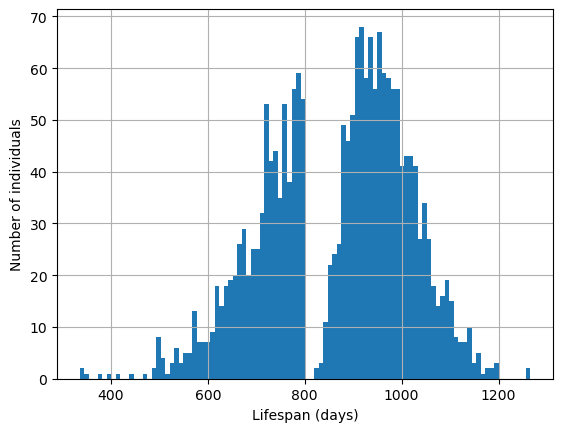

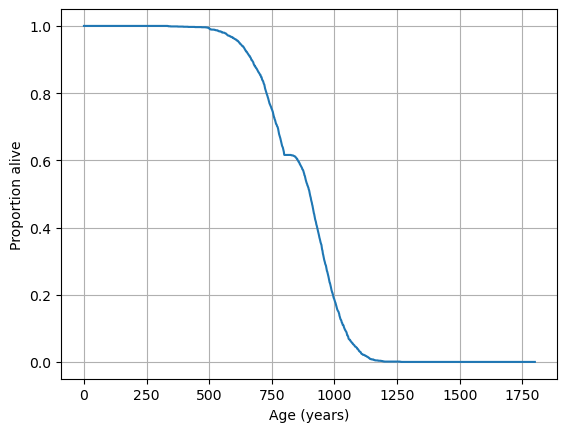

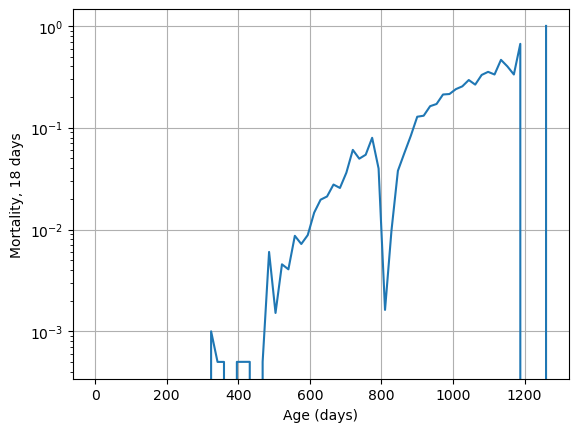

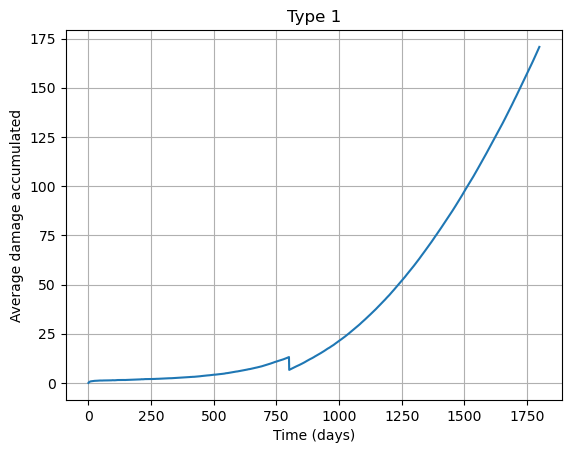

In [8]:
# Intervention directly repairs damage

def damage_repair_intervention(time, concentrations, dt, xi, parameter_list, proportion_repaired, repair_time):
    """
    Damage accumulation with a direct repair intervention at a specified time.

    Parameters:
        time (float): Current time.
        concentrations (array-like): Current damage values.
        dt (float): Time step.
        xi (float): Random normal variable for noise.
        parameter_list (list): Model parameters.
        proportion_repaired (float): Proportion of damage repaired.
        repair_time (float): Time at which repair occurs.

    Returns:
        array-like: Change in damage.
    """
    if time >= repair_time and time-dt < repair_time:
        # Repair damage
        amount_repaired = concentrations * proportion_repaired / dt
    else:
        amount_repaired = 0
    return single_damage_accumulation(time, concentrations, dt, xi, *parameter_list) - amount_repaired

eta = 2.4e-4 #/day²
beta = 0.15 #/day
kappa = 0.5
epsilon = 0.16 #/year
parameters = [[eta, beta, kappa, epsilon], 0.5, 800]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(damage_repair_intervention, death_cutoff_function, initial_damage,
                                       population_size=2000, dt=1, time_span=[0, 1800],
                                       time_unit="days", parameters=parameters,
                                       name = "Mouse direct damage repair")

A more complex model with two types of damage was made. Damage of type 1 is accumulated and repaired in the same way as in the previous model. The rate of accumulation for type 2 damage is proportional to the amount of type 1 damage. Only type 2 damage will kill the organism.

The equations are:

$$
\begin{aligned}
\frac{dA}{dt} &= \alpha_1 t - \beta_1 \frac{A}{A + K_1} + \sqrt{2 D_1} \, \xi \\
\frac{dB}{dt} &= \alpha_2 A - \beta_2 \frac{B}{B + K_2} + \sqrt{2 D_2} \, \xi
\end{aligned}
$$

where:

- $A$ is the amount of type 1 damage
- $B$ is the amount of type 2 damage
- $t$ is time (in days)
- $\alpha_1$ is the accumulation rate for type 1 damage
- $\beta_1$ is the repair rate for type 1 damage
- $K_1$ is the repair saturation constant for type 1 damage
- $D_1$ is the noise amplitude for type 1 damage
- $\alpha_2$ is the accumulation rate for type 2 damage (proportional to $A$)
- $\beta_2$ is the repair rate for type 2 damage
- $K_2$ is the repair saturation constant for type 2 damage
- $D_2$ is the noise amplitude for type 2 damage
- $\xi$ is Gaussian white noise

Parameters used:

- $\alpha_1 = 4.4 \times 10^{-4}$ $\mathrm{day}^{-2}$
- $\beta_1 = 0.15$ $\mathrm{day}^{-1}$
- $K_1 = 0.5$
- $D_1 = 0.16$ $\mathrm{day}^{-1}$
- $\alpha_2 = 4.8 \times 10^{-3}$ $\mathrm{day}^{-1}$
- $\beta_2 = 0.15$ $\mathrm{day}^{-1}$
- $K_2 = 0.5$
- $D_2 = 0.16$ $\mathrm{day}^{-1}$
- Damage cutoff: $B = 17$ (death occurs when type 2 damage exceeds this value)

Running aging simulation: Mouse two damage types
Individual 2000/2000
Average lifespan: 805.482 days
Median lifespan: 811.0 days
Standard deviation in lifespan: 91.8969513966595
Steepness: 8.76505681372668
99th percentile: 987.01 days


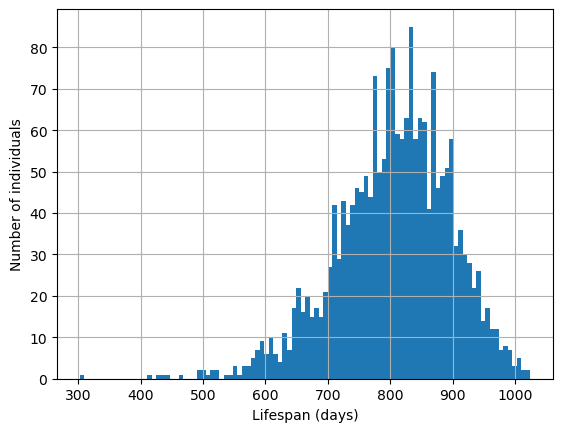

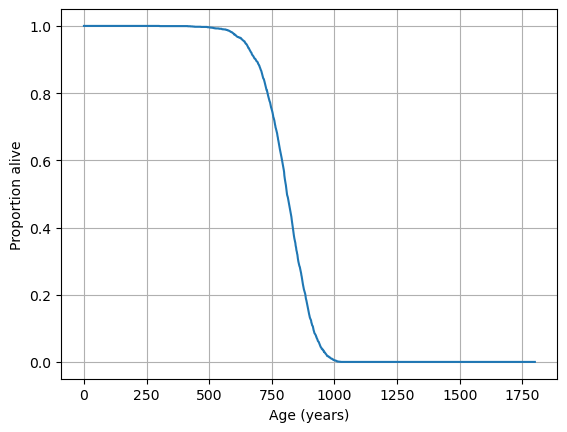

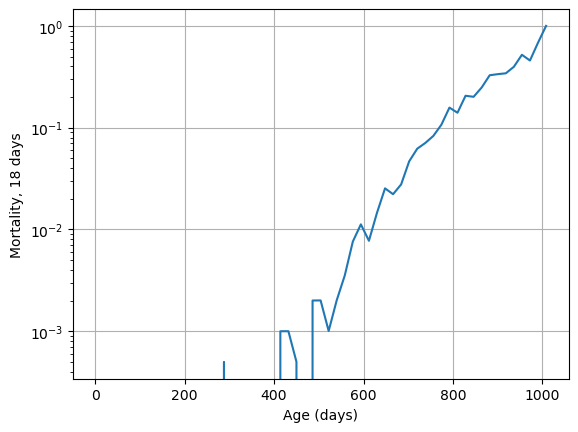

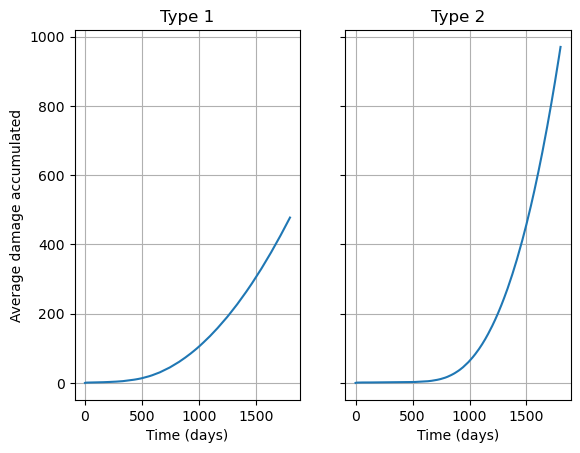

In [10]:
# Two types of damage

def type_2_kills(concentration_matrix):
    """
    Determine the time index when the second type of damage exceeds the death cutoff.

    Parameters:
        concentration_matrix (numpy.ndarray): Damage values over time.

    Returns:
        int: Index of death.
    """
    death_cutoff = 17
    death_index = numpy.argmax(concentration_matrix[:, 1] > death_cutoff)
    return death_index

def two_damage_types(time, concentrations, dt, xi, A_accumulation, A_repair, A_k, A_noise,
                     B_accumulation, B_repair, B_k, B_noise):
    """
    Compute the change in two types of damage for a single time step.

    Parameters:
        time (float): Current time.
        concentrations (array-like): Current damage values [A, B].
        dt (float): Time step.
        xi (float): Random normal variable for noise.
        A_accumulation, A_repair, A_k, A_noise (float): Parameters for damage type A.
        B_accumulation, B_repair, B_k, B_noise (float): Parameters for damage type B.

    Returns:
        numpy.ndarray: Change in [A, B] damage.
    """
    A = concentrations[0]
    B = concentrations[1]
    dA = dt * (A_accumulation*time - A_repair*A/(A+A_k)) + \
    numpy.sqrt(2*A_noise*dt)*xi
    dB = dt * (B_accumulation*A    - B_repair*B/(B+B_k)) + \
    numpy.sqrt(2*B_noise*dt)*xi
    return numpy.array([dA, dB])

A_accumulation = 4.4e-4
A_repair = 0.15
A_k = 0.5
A_noise = 0.16
B_accumulation = 4.8e-3
B_repair = 0.15
B_k = 0.5
B_noise = 0.16
parameters = [A_accumulation, A_repair, A_k, A_noise, B_accumulation, B_repair, B_k, B_noise]

initial_damage = numpy.zeros(2)

lifespan_array = population_simulation(two_damage_types, type_2_kills, initial_damage,
                                       population_size = 2000, dt = 1, time_span=[0, 1800],
                                       time_unit="days", parameters=parameters,
                                       name = "Mouse two damage types")